# Supervised UNET Segmentation 

From tutorial: https://www.kaggle.com/ateplyuk/pytorch-starter-u-net-resnet

Goal is to localizing and classifying surface defects on a steel sheet. Here implemented with UNET model.

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
import torch.nn.functional as F

## Dataset import

In [2]:
path = '/scratch/jonatank/data/severstal-steel-defect-detection/'

In [3]:
tr = pd.read_csv(path + 'train.csv')

print(len(tr))
tr.head()

7095


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [4]:
# Reomve Nan Envoded Pixels
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
# Only use class 1
df_train = df_train.loc[df_train['ClassId'] == 1]
# Drop "ClassId" column
df_train = df_train.drop(columns='ClassId')

print(len(df_train))
df_train.head()

897


,ImageId,EncodedPixels
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...
2,000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...
8,002fc4e19.jpg,146021 3 146275 10 146529 40 146783 46 147038 ...
18,008ef3d74.jpg,356336 4 356587 11 356838 18 357089 25 357340 ...
21,00ac8372f.jpg,101742 3 101998 12 102253 19 102301 22 102509 ...


The Image mask is encoded as follows:

"The competition format requires a space delimited list of pairs. For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc."

In [5]:
df_train["EncodedPixels"][0]

'29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53 89283 40 89539 32 89667 10 89795 30 89923 28 90050 29 90179 37 90306 27 90434 38 90562 14 90690 38 90817 9 90946 38 91073 3 91202 38 91458 38 91714 38 91969 39 92225 39 92481 39 92737 39 92993 39 93248 40 93504 40 93760 40 94026 30 94302 10 189792 7 190034 21 190283 28 190539 28 190795 28 191051 28 191307 28 191563 28 191819 28 192075 28 192331 28 192587 28 192843 23 193099 14 193355 5'

We decode the mask with this function:

In [6]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

/scratch/jonatank/anaconda3/envs/JKMT/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(0, 897 + 1) instead
  """


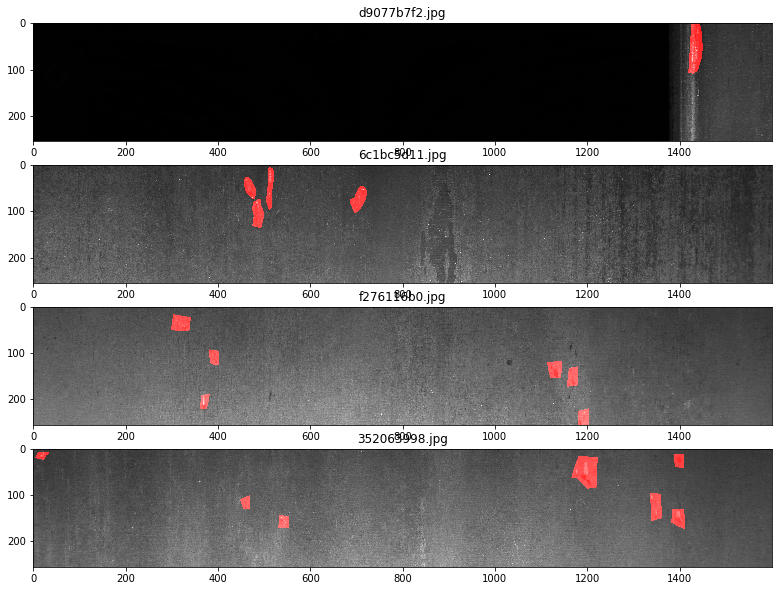

In [7]:
columns = 1
rows = 4
fig = plt.figure(figsize=(20,columns*rows+6))
for i in range(1,columns*rows+1):
    idx = np.random.random_integers(0,len(df_train))
    fn = df_train['ImageId'].iloc[idx]
    
    fig.add_subplot(rows, columns, i).set_title(fn)
    img = cv2.imread( path + 'train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(df_train['EncodedPixels'].iloc[idx], (256, 1600))
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()

## Split dataset to train/valid

In [8]:
class ImageData(Dataset):
    def __init__(self, df, transform, subset="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset
        
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):                      
        fn = self.df['ImageId'].iloc[index]         
        img = Image.open(self.data_path + fn)
        img = self.transform(img)

        if self.subset == 'train': 
            mask = rle2mask(self.df['EncodedPixels'].iloc[index], (256, 1600))
            mask = transforms.ToPILImage()(mask)            
            mask = self.transform(mask)
            return img, mask
        else: 
            mask = None
            return img     

In [9]:
data_transf = transforms.Compose([
                                  transforms.Scale((256, 256)),
                                  transforms.ToTensor()])

train_data = ImageData(df = df_train, transform = data_transf)

train_loader = DataLoader(dataset = train_data, batch_size=4)

/scratch/jonatank/anaconda3/envs/JKMT/lib/python3.7/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [10]:
train_data[1][1].size()

torch.Size([1, 256, 256])

/scratch/jonatank/anaconda3/envs/JKMT/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(0, 897 + 1) instead
  """


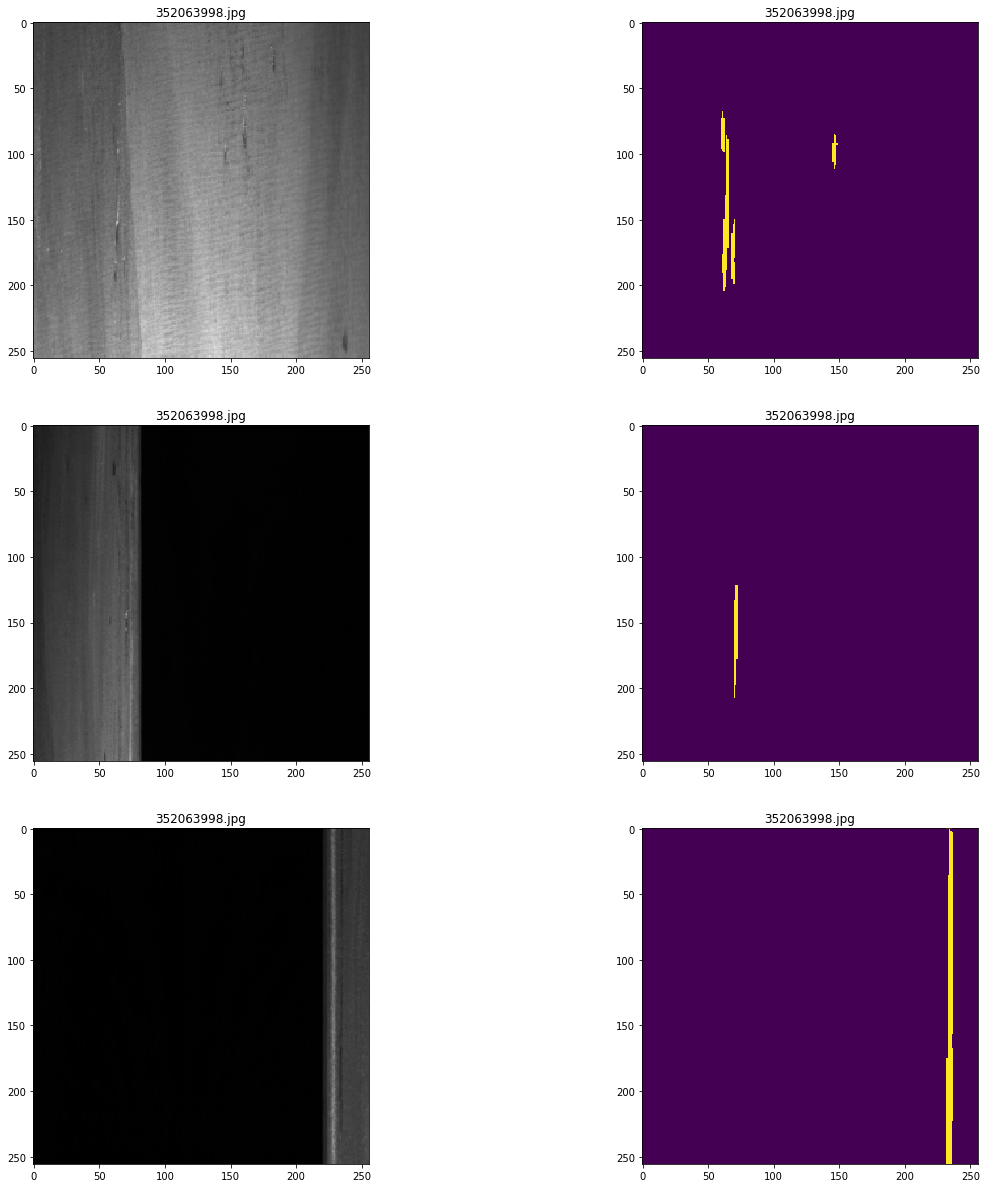

In [11]:
rows = 3
columns = 2
fig = plt.figure(figsize=(20,columns*rows+15))
for i in range(3):
    idx = np.random.random_integers(0,len(df_train))
    print()
    fig.add_subplot(rows,columns,2*i+1).set_title(fn)
    plt.imshow(train_data[idx][0].permute(1, 2, 0))
    fig.add_subplot(rows,columns,2*i+2).set_title(fn)
    plt.imshow(np.squeeze(train_data[idx][1].permute(1, 2, 0)))
    
plt.show()

## Create UNET model

In [12]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        self.base_model.load_state_dict(torch.load("resnet18.pth/resnet18.pth"))
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out


In [181]:
model = UNet(n_class=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = 0.001, momentum=0.9)

In [193]:
for epoch in range(5):      
    model.train()         
    for ii, (data, target) in enumerate(train_loader):
        output = model(data)  
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()          
    print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, loss.item()))

Epoch: 1 - Loss: 0.006822
Epoch: 2 - Loss: 0.004030
Epoch: 3 - Loss: nan
Epoch: 4 - Loss: nan
Epoch: 5 - Loss: nan


/scratch/jonatank/anaconda3/envs/JKMT/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(0, 897 + 1) instead
  """
/scratch/jonatank/anaconda3/envs/JKMT/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/scratch/jonatank/anaconda3/envs/JKMT/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


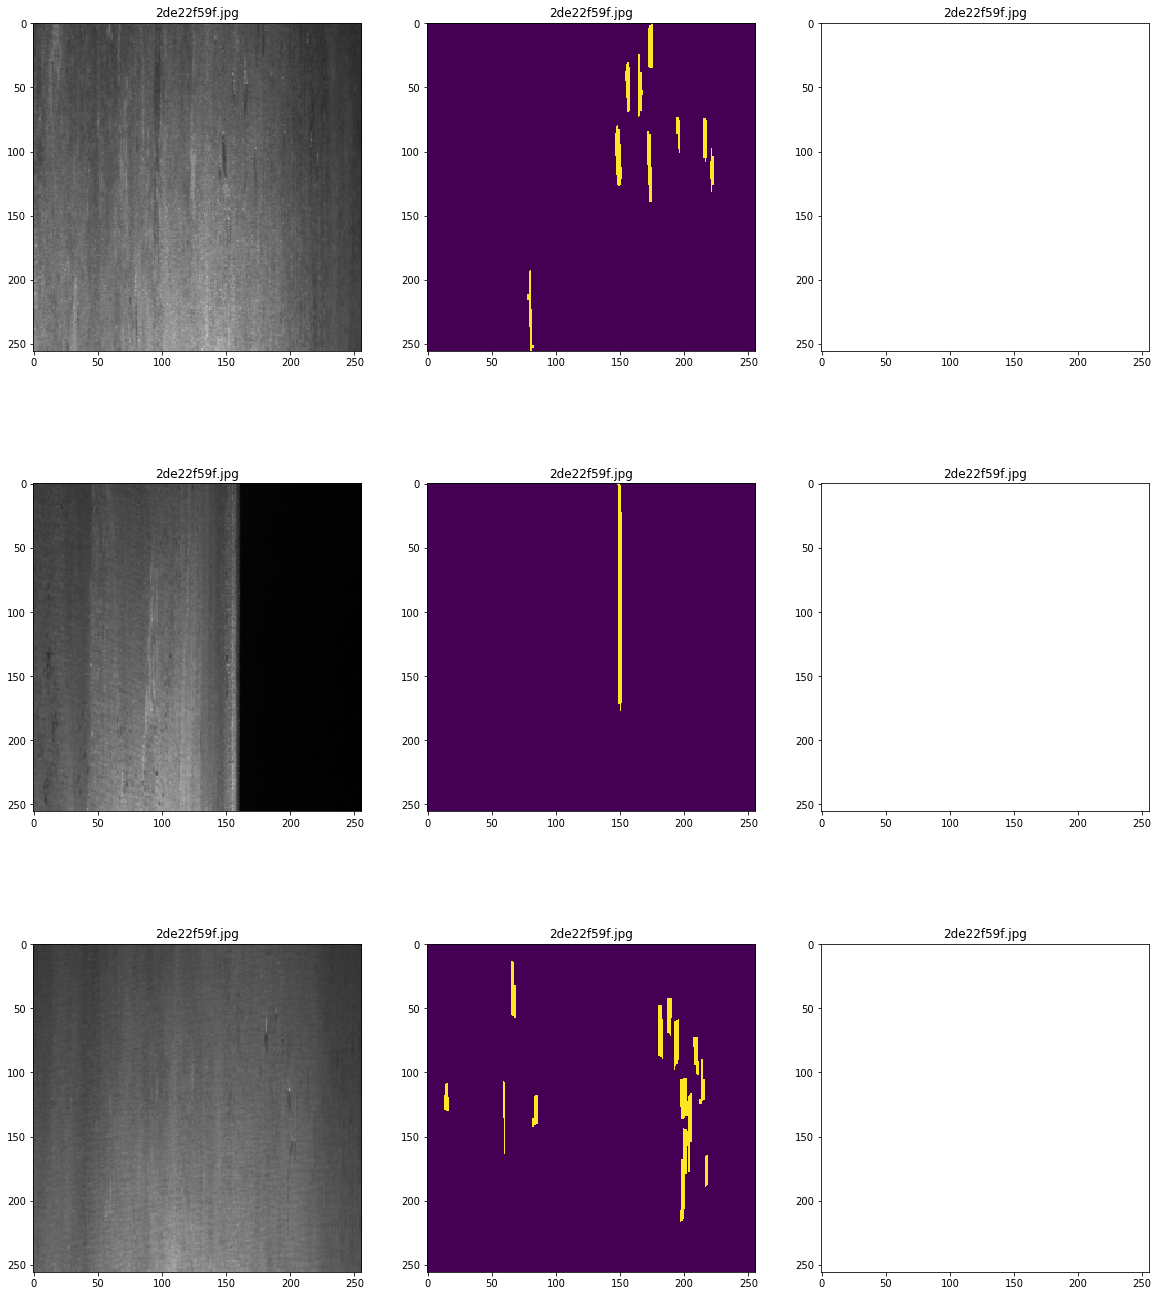

In [197]:
rows = 3
columns = 3
fig = plt.figure(figsize=(20,columns*rows+15))
for i in range(3):
    idx = np.random.random_integers(0,len(df_train))

    fig.add_subplot(rows,columns,3*i+1).set_title(fn)
    plt.imshow(train_data[idx][0].permute(1, 2, 0))
    fig.add_subplot(rows,columns,3*i+2).set_title(fn)
    plt.imshow(np.squeeze(train_data[idx][1].permute(1, 2, 0)))
    
    x = train_data[idx][0].unsqueeze(0)
    o = model(x)  
    o = o.cpu().detach().numpy() * (-1)
    tmp = np.copy(o)
    mn = np.mean(o)*1.2
    tmp[tmp<mn] = 0
    tmp[tmp>mn] = 1
    
    fig.add_subplot(rows,columns,3*i+3).set_title(fn)
    plt.imshow(np.squeeze(tmp))
    
plt.show()